In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
sns.set_style('darkgrid')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
preddir = '/home/rasp/data/myWeatherBench/predictions/'
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [7]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [8]:
valid = valid.isel(time=slice(0, None, 12))

In [9]:
rmse_baseline = read_pickle('./rmse.pkl')
rmse_weyn = xr.open_dataset('./weyn_rmse.nc').rename({'z_rmse': "z", 't_rmse': 't'})

## get scores for direct predictions

In [10]:
def get_direct_scores_from_nc(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS):
    scores = []
    for exp_id in tqdm(exp_ids):
        fn = glob(f'{preddir}{exp_id}*.nc')[0]
        preds = xr.open_dataset(fn)
        scores.append(
            func(
                preds, 
                valid,
                mean_dims
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [11]:
rmse_direct = get_direct_scores_from_nc([129, 130, 131, 132], [6, 24, 72, 120])

In [20]:
rmse_direct.to_netcdf('./rmse_direct_pre.nc')

In [51]:
def get_direct_train_scores(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS, years=['2014', '2015']):
    scores = []
    for exp_id in tqdm(exp_ids):
        fn = glob(f'../nn_configs/B/{exp_id}*.yml')[0]
        args = load_args(fn)
        model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})

        mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
        std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
        args['ext_mean'] = mean
        args['ext_std'] = std
        args['train_years'] = years
        dg_train, dg_valid, dg_test = load_data(**args)
        dg_train.shuffle = False; dg_train.on_epoch_end()

        preds_train = create_predictions(model, dg_train)
        scores.append(
            compute_weighted_rmse(
                preds_train, 
                valid
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [52]:
rmse_direct_train = get_direct_train_scores([129, 130, 131, 132], [6, 24, 72, 120])

## get scores for contiuous

In [15]:
def get_cont_scores(exp_id, lead_times, func=compute_weighted_rmse, train_years=['2014', '2015'], train=False):
    lead_times = xr.DataArray(lead_times, dims={'lead_time': lead_times}, name='lead_time')
    fn = glob(f'../nn_configs/B/{exp_id}*.yml')[0]
    args = load_args(fn)
    model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})
    
    mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
    std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
    args['ext_mean'] = mean
    args['ext_std'] = std
    args['train_years'] = train_years
    
    if train:
        dg, _, _ = load_data(**args)
        dg.shuffle = False; dg.on_epoch_end(); 
    else:
        dg = load_data(**args, only_test=True)
    dg.old_const=True
    dg.fixed_time = True
    preds = []
    for l in tqdm(lead_times):
        dg.lead_time = l.values; dg.on_epoch_end()
        p = create_predictions(model, dg)
        p['time'] = dg.init_time
        preds.append(p)
    preds = xr.concat(preds, lead_times)
    return evaluate_iterative_forecast(preds, valid, func)

In [16]:
rmse_cont = get_cont_scores(128, [2, 6, 12, 24, 48, 72, 96, 120])

In [17]:
rmse_cont.to_netcdf('./rmse_cont_pre.nc')

In [ ]:
rmse_cont_train = get_cont_scores(128, [2, 6, 12, 24, 48, 72, 96, 120], train=True)

## Plot scores

In [22]:
rmse_direct = xr.open_dataset('rmse_direct_pre.nc')
rmse_cont = xr.open_dataset('rmse_cont_pre.nc')

In [14]:
rmse_cont1 = xr.open_dataset("rmse_cont.nc").rename({'z_rmse': "z", 't_rmse': 't'}).sel(lead_time=slice(0, 120))

In [38]:
rmse_direct1 = xr.open_dataset("rmse_direct.nc").rename({'z_rmse': "z", 't_rmse': 't', 'concat_dim': 'lead_time'})

In [27]:
def plot_zt(ds, label, **kwargs):
    ds.z.plot(ax=ax1, label=label, lw=3, **kwargs)
    ds.t.plot(ax=ax2, lw=3, **kwargs)

(0.0, 3.5)

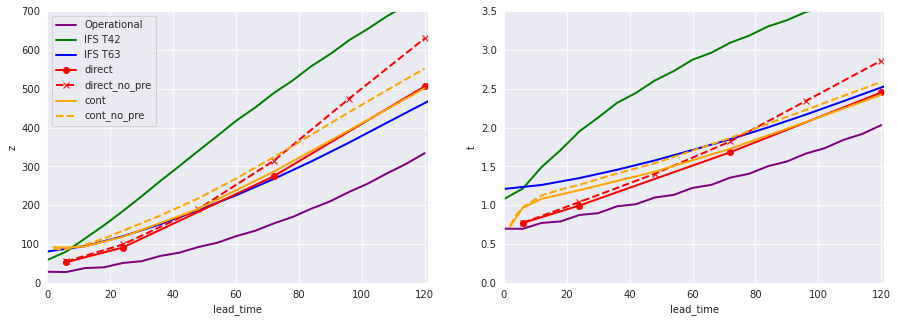

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_baseline['Operational'], 'Operational', c='purple')
plot_zt(rmse_baseline['IFS T42'], 'IFS T42', c='green')
plot_zt(rmse_baseline['IFS T63'], 'IFS T63', c='blue')
plot_zt(rmse_direct, 'direct', c='r', marker='o')
plot_zt(rmse_direct1, 'direct_no_pre', c='r', marker='x', ls='--')
plot_zt(rmse_cont, 'cont', c='orange')
plot_zt(rmse_cont1, 'cont_no_pre', c='orange', ls='--')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
ax1.set_ylim(0, 700)
ax2.set_ylim(0, 3.5)

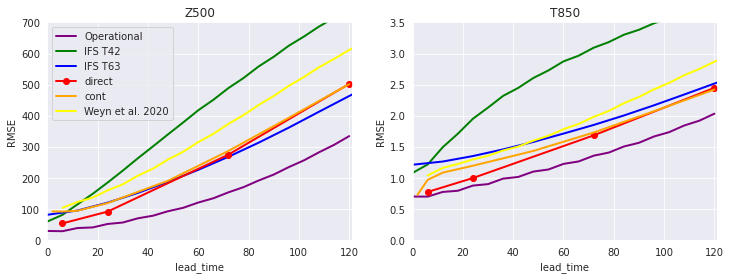

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_zt(rmse_baseline['Operational'], 'Operational', c='purple')
plot_zt(rmse_baseline['IFS T42'], 'IFS T42', c='green')
plot_zt(rmse_baseline['IFS T63'], 'IFS T63', c='blue')
plot_zt(rmse_direct, 'direct', c='r', marker='o')
# plot_zt(rmse_direct1, 'direct_no_pre', c='r', marker='x', ls='--')
plot_zt(rmse_cont, 'cont', c='orange')
plot_zt(rmse_weyn, 'Weyn et al. 2020', c='yellow')
# plot_zt(rmse_cont1, 'cont_no_pre', c='orange', ls='--')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
    ax.set_ylabel('RMSE')
ax1.set_ylim(0, 700)
ax2.set_ylim(0, 3.5)
ax1.set_title('Z500')
ax2.set_title('T850');

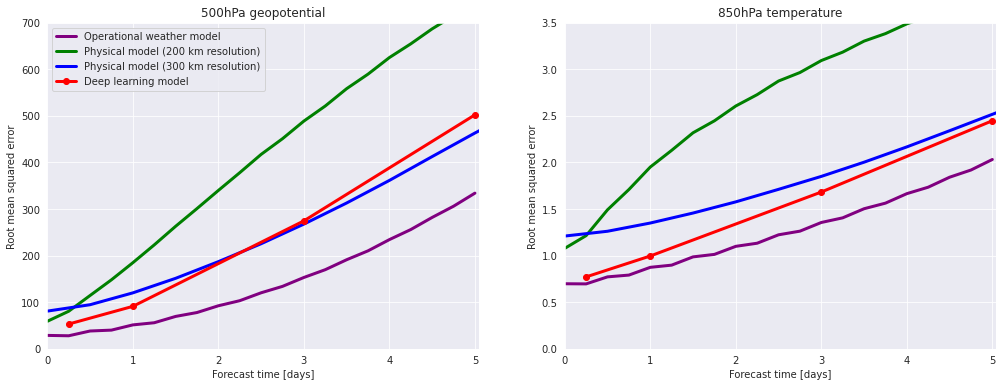

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
plot_zt(rmse_baseline['Operational'], 'Operational weather model', c='purple')
plot_zt(rmse_baseline['IFS T42'], 'Physical model (200 km resolution)', c='green')
plot_zt(rmse_baseline['IFS T63'], 'Physical model (300 km resolution)', c='blue')
plot_zt(rmse_direct, 'Deep learning model', c='r', marker='o')
# plot_zt(rmse_direct1, 'direct_no_pre', c='r', marker='x', ls='--')
# plot_zt(rmse_cont, 'cont', c='orange')
# plot_zt(rmse_weyn, 'Weyn et al. 2020', c='yellow')
# plot_zt(rmse_cont1, 'cont_no_pre', c='orange', ls='--')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
    ax.set_ylabel('Root mean squared error')
    ax.set_xticks(np.arange(0, 121, 24))
    ax.set_xticklabels(np.arange(0, 6, 1))
    ax.set_xlabel('Forecast time [days]')
ax1.set_ylim(0, 700)
ax2.set_ylim(0, 3.5)
ax1.set_title('500hPa geopotential')
ax2.set_title('850hPa temperature')
fig.savefig('./cai.pdf', bbox_inches='tight')

## generalization error

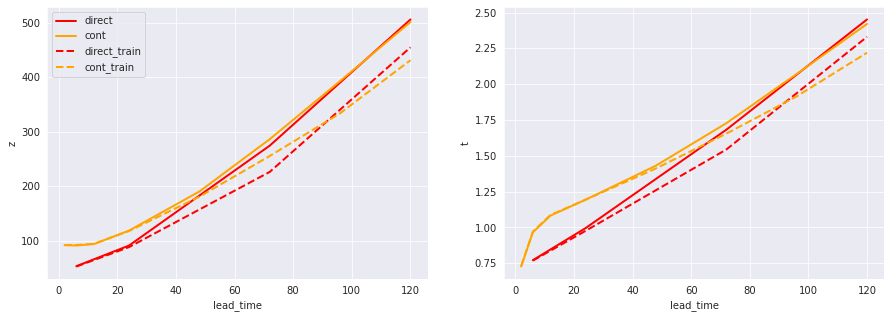

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_direct, 'direct', c='r')
plot_zt(rmse_cont, 'cont', c='orange')
plot_zt(rmse_direct_train, 'direct_train', c='r', ls='--')
plot_zt(rmse_cont_train, 'cont_train', c='orange', ls='--')
ax1.legend()

In [119]:
gen_direct = (rmse_direct - rmse_direct_train)
gen_cont = (rmse_cont - rmse_cont_train)

In [120]:
gen_direct_rel = (rmse_direct - rmse_direct_train) / (rmse_direct_train + rmse_direct) / 2
gen_cont_rel = (rmse_cont - rmse_cont_train) / (rmse_cont_train + rmse_cont) / 2

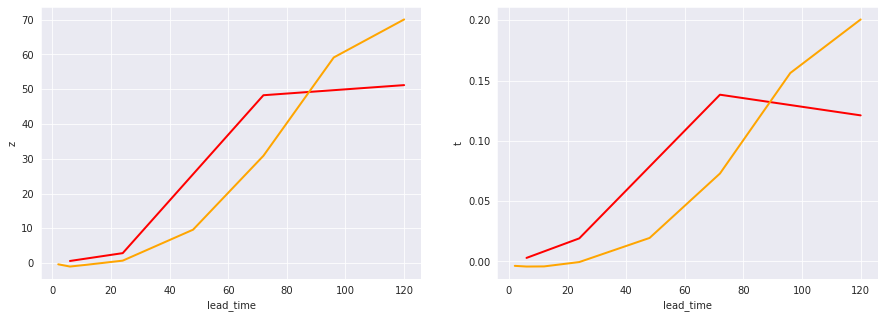

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(gen_direct, 'direct', c='r')
plot_zt(gen_cont, 'cont', c='orange')

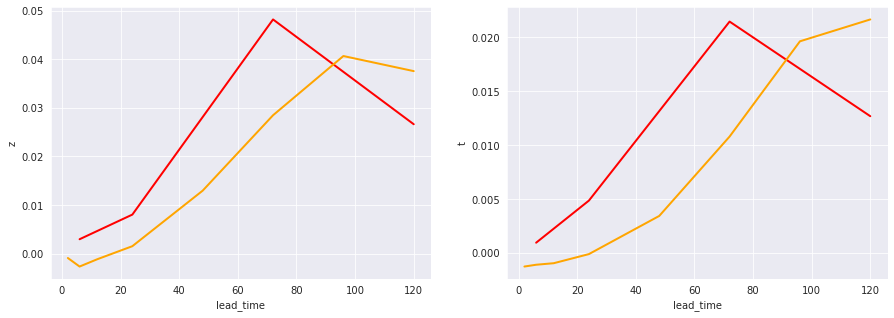

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(gen_direct_rel, 'direct', c='r')
plot_zt(gen_cont_rel, 'cont', c='orange')

## Pretraining evaluation

### Direct 

In [10]:
cmip = ['123-resnet_d3_1d_cmip', '125-resnet_d3_3d_cmip', '127-resnet_d3_5d_cmip']
era = ['130-resnet_d3_1d_pre_cmip', '131-resnet_d3_3d_pre_cmip', '132-resnet_d3_5d_pre_cmip']
cmip_scores = []; era_scores = []
for c, e in tqdm(zip(cmip, era)):
    args_cmip = load_args(f'../nn_configs/B/{c}.yml')
    args_era = load_args(f'../nn_configs/B/{e}.yml')
    model_cmip = load_model(args_cmip)
    model_era = load_model(args_era)
    dg_test = load_data(**args_era, only_test=True)
    preds_cmip = create_predictions(model_cmip, dg_test)
    preds_era = create_predictions(model_era, dg_test)
    cmip_scores.append(compute_weighted_rmse(preds_cmip, valid).compute())
    era_scores.append(compute_weighted_rmse(preds_era, valid).compute())

In [12]:
cmip2 = ['145-resnet_d3_5d_cmip2']
era2 = ['149-resnet_d3_5d_pre_cmip2']
cmip_scores2 = []; era_scores2 = []
for c, e in tqdm(zip(cmip2, era2)):
    args_cmip = load_args(f'../nn_configs/B/{c}.yml')
    args_era = load_args(f'../nn_configs/B/{e}.yml')
    model_cmip = load_model(args_cmip)
    model_era = load_model(args_era)
    dg_test = load_data(**args_era, only_test=True)
    preds_cmip = create_predictions(model_cmip, dg_test)
    preds_era = create_predictions(model_era, dg_test)
    cmip_scores2.append(compute_weighted_rmse(preds_cmip, valid).compute())
    era_scores2.append(compute_weighted_rmse(preds_era, valid).compute())

In [23]:
cmip3 = ['134-resnet_no_dr_3d_cmip']
era3 = ['135-resnet_no_dr_3d_pre_cmip']
cmip_scores3 = []; era_scores3 = []
for c, e in tqdm(zip(cmip3, era3)):
    args_cmip = load_args(f'../nn_configs/B/{c}.yml')
    args_era = load_args(f'../nn_configs/B/{e}.yml')
    model_cmip = load_model(args_cmip)
    model_era = load_model(args_era)
    dg_test = load_data(**args_era, only_test=True)
    preds_cmip = create_predictions(model_cmip, dg_test)
    preds_era = create_predictions(model_era, dg_test)
    cmip_scores3.append(compute_weighted_rmse(preds_cmip, valid).compute())
    era_scores3.append(compute_weighted_rmse(preds_era, valid).compute())

In [19]:
cmip_scores

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 173.0
     t        float64 1.333,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 326.2
     t        float64 2.015,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 535.1
     t        float64 2.703]

In [20]:
era_scores

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 91.1
     t        float64 0.9958,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 274.6
     t        float64 1.682,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 506.2
     t        float64 2.452]

In [21]:
cmip_scores2

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 573.9
     t        float64 2.835]

In [22]:
era_scores2

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 519.7
     t        float64 2.521]

In [24]:
cmip_scores3

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 309.3
     t        float64 1.961]

In [25]:
era_scores3

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 262.8
     t        float64 1.641]

In [26]:
X, y = dg_test[0]

In [27]:
X.shape

(32, 32, 64, 108)

In [29]:
(5*7+3)*3

114

## C all vs zt

In [115]:
tp = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc',combine='by_coords').sel(time=slice('2014', '2018', None))
t2m = xr.open_mfdataset(f'{args["datadir"]}/2m_temperature/*.nc',combine='by_coords').sel(time=slice('2014', '2018', None))
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')

In [116]:
valid2 = xr.merge([z500_valid, t850_valid, tp, t2m])

In [118]:
valid2=valid2.isel(time=slice(0, None, 12))

In [119]:
valid2

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3652)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>

In [103]:
args = load_args('../nn_configs/C/001-resnet_d3_all_3d.yml')

In [104]:
dg_test = load_data(**args, only_test=True)

In [105]:
model = load_model(args)

In [106]:
preds = create_predictions(model, dg_test)

In [107]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    tp       (time, lat, lon) float64 2.168e-19 2.168e-19 ... 0.0001333 0.000116
    t        (time, lat, lon) float64 256.4 256.5 256.5 ... 249.8 249.7 249.4
    z        (time, lat, lon) float64 5.055e+04 5.052e+04 ... 4.91e+04 4.908e+04
    t2m      (time, lat, lon) float64 247.0 246.9 246.7 ... 249.0 248.6 247.9

In [108]:
compute_weighted_rmse(preds, valid2).load()

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 nan
    t        float64 2.002
    z        float64 355.2
    t2m      float64 nan

In [120]:
args = load_args('../nn_configs/C/002-resnet_d3_all_3d_tfr.yml')

In [121]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:22:12.374400
DG normalize 10:22:12.419459
DG load 10:22:12.427545
DG done 10:22:12.427587


In [122]:
model = load_model(args)

In [123]:
preds = create_predictions(model, dg_test)

In [124]:
compute_weighted_rmse(preds, valid2).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.002203
    t        float64 1.985
    z        float64 349.0
    t2m      float64 1.766

In [125]:
args = load_args('../nn_configs/C/003-resnet_d3_zt_3d.yml')

In [126]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:23:03.285211
DG normalize 10:23:03.330763
DG load 10:23:03.338740
DG done 10:23:03.338792


In [127]:
model = load_model(args)

In [128]:
preds = create_predictions(model, dg_test)

In [129]:
compute_weighted_rmse(preds, valid2).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 1.818
    z        float64 313.9

In [42]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/013-resnet_d3_zt_3d_pre.nc')

In [44]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 296.4
    t        float64 1.751

## 11/22 deg

In [10]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [11]:
valid = valid.isel(time=slice(0, None, 12))

In [31]:
args = load_args('../nn_configs/C/004-resnet_d3_zt_3d_11deg.yml')
model = load_model(args)
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
args['train_years'] = ['2014', '2015']
dg_train, dg_valid, dg_test = load_data(**args)

DG start 21:28:12.565489
DG normalize 21:28:12.608304
DG load 21:28:12.616215
Loading data into RAM
DG done 21:28:15.412002


In [32]:
preds = create_predictions(model, dg_test)
preds_train = create_predictions(model, dg_train)

In [33]:
preds = regrid(preds, ddeg_out=5.625)
preds_train = regrid(preds_train, ddeg_out=5.625)

Reuse existing file: bilinear_16x32_32x64_peri.nc
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable

In [34]:
rmse11 = compute_weighted_rmse(preds, valid).compute()
rmse11_train = compute_weighted_rmse(preds_train, valid).compute()

In [19]:
args = load_args('../nn_configs/C/005-resnet_d3_zt_3d_22deg.yml')
model = load_model(args)
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
dg_test = load_data(**args, only_test=True)

In [20]:
preds = create_predictions(model, dg_test)

In [21]:
preds = regrid(preds, ddeg_out=5.625)

Reuse existing file: bilinear_8x16_32x64_peri.nc
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable 

In [22]:
rmse22 = compute_weighted_rmse(preds, valid).compute()

In [23]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions/81-resnet_d3_dr_0.1_fixed.nc')

In [24]:
rmse5 = compute_weighted_rmse(preds, valid).compute()

In [30]:
rmse11

<xarray.Dataset>
Dimensions:  (time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
Data variables:
    t        (time) float64 2.367 2.424 2.571 2.563 ... 2.268 2.409 2.318 2.379
    z        (time) float64 432.3 446.4 457.9 449.1 ... 387.8 388.9 394.9 402.7

In [35]:
rmse = xr.concat([rmse5, rmse11, rmse22], dim=[5.625, 11.25, 22.5])

In [36]:
rmse

<xarray.Dataset>
Dimensions:     (concat_dim: 3)
Coordinates:
  * concat_dim  (concat_dim) float64 5.625 11.25 22.5
Data variables:
    z           (concat_dim) float64 314.2 424.1 687.8
    t           (concat_dim) float64 1.823 2.391 3.337

In [40]:
rmse_pre = [280, 407, 684]

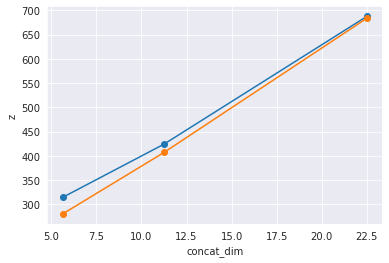

In [41]:
rmse.z.plot(marker='o')
plt.plot([5.625, 11.25, 22.5], rmse_pre, marker='o')

## Fluctuations

In [8]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('1979', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('1979', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [9]:
valid = valid.isel(time=slice(0, None, 12))

In [10]:
clim = valid.mean('time')

In [11]:
rmse = compute_weighted_rmse(clim, valid, ['lat', 'lon']).load()

In [16]:
rmse_y = rmse.groupby('time.year').mean()

In [21]:
rel = rmse_y / rmse_y.mean('year')

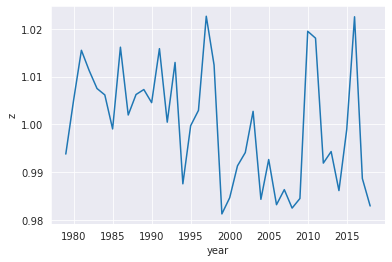

In [22]:
rel.z.plot()

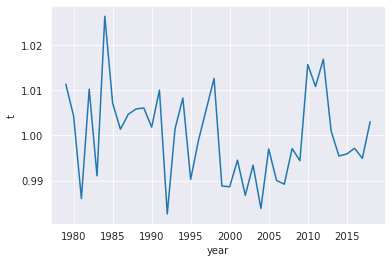

In [23]:
rel.t.plot()